In [1]:
from typing import Union
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid, numpy_to_pil
import torch
import numpy as np
import PIL
from PIL import Image, ImageShow
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

/workspace/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def show(image: Union[str, PIL.Image.Image], downsize_ratio: int = 1):
    if isinstance(image, PIL.Image.Image):
        pass
    else:
        image = Image.open(img_path)
    viewer = ImageShow.IPythonViewer()
    width = image.width // downsize_ratio
    height = image.height // downsize_ratio
    resized_img = image.resize((width, height))
    viewer.show(image=resized_img)

In [4]:
# Load IP-Adapter Inpainting pipeline
inpainting_base_model = 'runwayml/stable-diffusion-inpainting'
ip_adapter_model = 'h94/IP-Adapter'
pipeline = AutoPipelineForInpainting.from_pretrained(inpainting_base_model, 
                                                     variant='fp16',
                                                     torch_dtype=torch.float16
                                                    ).to('cuda')
pipeline.load_ip_adapter(ip_adapter_model, subfolder='models', weight_name='ip-adapter_sd15.bin')
pipeline.set_ip_adapter_scale(1.0)

/workspace/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/workspace/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


In [5]:
class Masker:
    def __init__(self, model_id='mattmdjaga/segformer_b2_clothes'): # SegFormer
        self.processor = SegformerImageProcessor.from_pretrained(model_id)
        self.model = AutoModelForSemanticSegmentation.from_pretrained(model_id)

    def get_binary_mask(self, image, return_pil=False):
        inputs = self.processor(images=image, return_tensors="pt")        
        outputs = self.model(**inputs)
        logits = outputs.logits.cpu()
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0] # Dunno how this line work
        np_image = np.array(image)
        np_image[pred_seg != 4] = 0
        np_image[pred_seg == 4] = 255
        binary_mask = ((pred_seg == 4) * 255).numpy().astype(np.uint8)

        return Image.fromarray(binary_mask) if return_pil else binary_mask

In [6]:
masker = Masker()

/workspace/venv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [21]:
image = load_image('../images/male_model.jpg')
# ip_image = load_image('../data/img1.jpg')
ip_image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/3_SERySTDoN8ixf8kZUg4.jpeg')
mask_image = masker.get_binary_mask(image, return_pil=True)

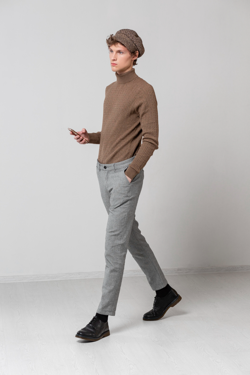

In [14]:
show(image, 4)

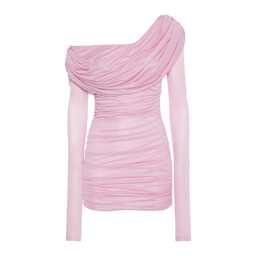

In [24]:
show(ip_image, 2)

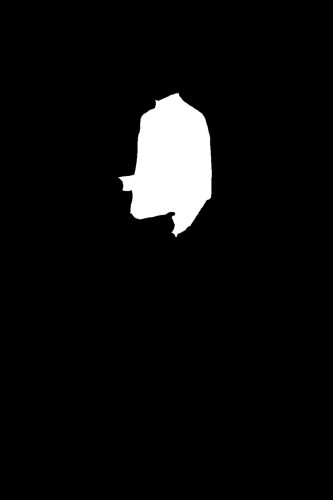

In [10]:
show(mask_image, 3)

100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


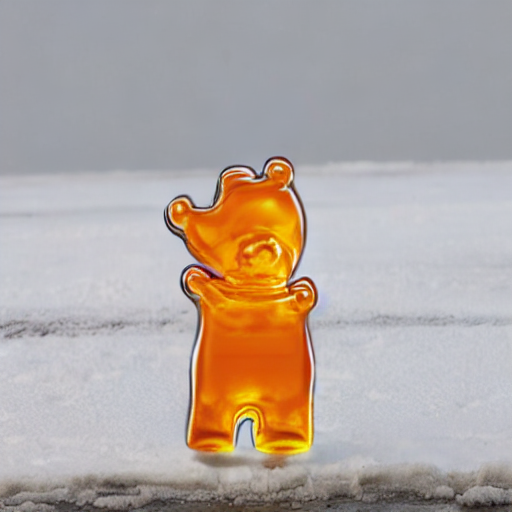

In [37]:
generator = torch.Generator(device="cuda").manual_seed(3)
images = pipeline(
    prompt="a man",
    # negative_prompt="ugly, bad quality",
    image=image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    generator=generator,
    num_inference_steps=100,
).images
images[0]

100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


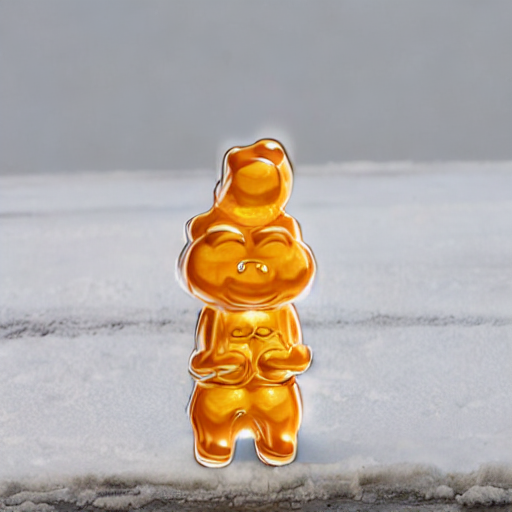

In [39]:
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_mask.png")
image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_bear_1.png")
ip_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_gummy.png")

generator = torch.Generator(device="cpu").manual_seed(4)
images = pipeline(
    prompt="",
    image=image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    generator=generator,
    num_inference_steps=100,
).images
images[0]